In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "chicago_taxi_trips" dataset
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "taxi_trips" table
table_ref = dataset_ref.table("taxi_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

In [ ]:
avg_num_trips_query = """
                      WITH trips_by_day AS
                      (
                      SELECT DATE(trip_start_timestamp) AS trip_date,
                          COUNT(*) as num_trips
                      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      WHERE trip_start_timestamp >= '2016-01-01' AND trip_start_timestamp < '2018-01-01'
                      GROUP BY trip_date
                      ORDER BY trip_date
                      )
                      SELECT trip_date,
                          AVG(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING
                               ) AS avg_num_trips
                      FROM trips_by_day
                      """

In [ ]:
trip_number_query = """
                    SELECT pickup_community_area,
                        trip_start_timestamp,
                        trip_end_timestamp,
                        RANK()
                            OVER (
                                  PARTITION BY pickup_community_area
                                  ORDER BY trip_start_timestamp
                                 ) AS trip_number
                    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                    WHERE DATE(trip_start_timestamp) = '2017-05-01' 
                    """

trip_number_result = client.query(trip_number_query).result().to_dataframe()

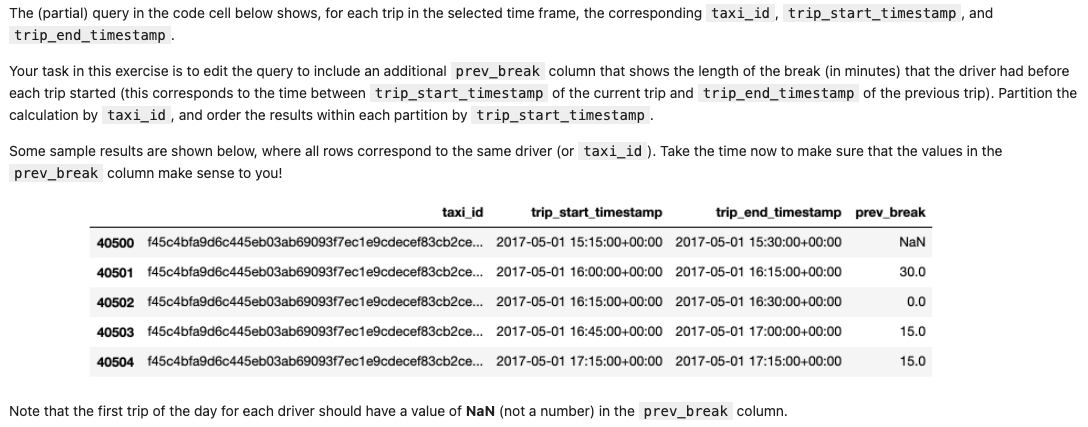

In [ ]:
break_time_query = """
                   SELECT taxi_id,
                       trip_start_timestamp,
                       trip_end_timestamp,
                       TIMESTAMP_DIFF(
                           trip_start_timestamp, 
                           LAG(trip_end_timestamp, 1) OVER (PARTITION BY taxi_id ORDER BY trip_start_timestamp), 
                           MINUTE) as prev_break
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE DATE(trip_start_timestamp) = '2017-05-01' 
                   """

break_time_result = client.query(break_time_query).result().to_dataframe()